In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time
from mpl_toolkits.mplot3d import Axes3D 
import scipy

In [2]:
import gymnasium
from gymnasium import spaces

In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

In [4]:
x0, y0 = 4, 4

### Finite Element Model of the Space Frame Element

In [5]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [6]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R) 

In [7]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [8]:
def total_length(coord,elcon):
    coord=np.array(coord)
    elcon=np.array(elcon)
    t_length=0
    for i in range(len(elcon)):
        l=PlaneTrussElementLength(coord[elcon[i][0]][0],\
                                    coord[elcon[i][0]][1],\
                                    coord[elcon[i][0]][2],\
                                    coord[elcon[i][1]][0],\
                                    coord[elcon[i][1]][1],\
                                    coord[elcon[i][1]][2])
        t_length+=l        
    return t_length 

In [9]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force, 
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    
    K=np.ones(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))*(1e-4)
    
    
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        
        K=SpaceFrameAssemble(K, k, el[0], el[1])
        
    F = np.array(global_force)
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
    compliance=d.T @ K @ d
    
#     return d, compliance, total_length(coord,elcon)
    return d, compliance, _

In [10]:
# 10 The Space Frame Element - verification

In [11]:
d, compliance, t_length  =FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        global_force=[-10,0,20,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0])

In [12]:
d

array([-7.05147750e-06, -6.65367104e-08,  1.41769582e-05,  1.44778791e-06,
        1.74858420e-06,  1.13605430e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [13]:
compliance

0.0003540539387047346

In [14]:
t_length

''

### RL model

In [15]:
class Model:
    def __init__(self, x):
        self.flag_ = True
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1

In [16]:
def draw(coord, elcon, elev=45, azim=45, color='red', flip=False):
    c = np.array(coord)
    e = np.array(elcon)

    if e.size == 0:
        print("Warning: 'elcon' is empty. Nothing to draw.")
        return

    try:
        coord = c.reshape(np.max(e) + 1, 3)
    except Exception as ex:
        print(f"Error reshaping coord: {ex}")
        return

    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_subplot(111, projection='3d')

    for item in e:
        ax.plot([coord[item[0]][0], coord[item[1]][0]],
                [coord[item[0]][1], coord[item[1]][1]],
                [coord[item[0]][2], coord[item[1]][2]],
                color=color, linewidth=5)

    ax.view_init(elev, azim)
    ax.set_xlim([0, 5])
    ax.set_ylim([0, 5])
    ax.set_zlim([0, 5]) 
    
    if flip:
        ax.set_zlim(ax.get_zlim()[::-1])
        
    plt.show()
    

In [17]:
class CantileverEnv(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        DIM = x0*y0
        N_DISCRETE_ACTIONS = x0*y0
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = np.zeros((y0, x0))
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        self.ext_reward=0

        
    def step(self, action):
        
        
        self.M.action_space_(action, self.x)        
        self.step_+=1
               
        done=False
                  
        if self.step_>0.7*x0*y0:
            done=True            
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
        
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.ext_reward, done, False, dict()

    def reset(self, seed=0):
                   
        self.x = np.zeros((y0, x0))

        self.reward=0
        self.needs_reset = False
        self.step_=0
        self.ext_reward=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        pass   

    def close(self):
        pass

In [18]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            
            
            
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
#             print(y)
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                
                mean_reward = np.mean(y[-100:])
                
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [19]:
def reconstruct_3d_structure(xy_plane, yz_plane, xz_plane):
    """
    Reconstructs a 3D structure from three 2D projections using extrusion and intersection.

    Parameters:
        xy_plane (ndarray): 2D binary array (X by Y) projection in XY plane.
        yz_plane (ndarray): 2D binary array (Y by Z) projection in YZ plane.
        xz_plane (ndarray): 2D binary array (X by Z) projection in XZ plane.

    Returns:
        volume (ndarray): 3D binary array (X by Y by Z) representing the reconstructed structure.
    """
    x_dim, y_dim = xy_plane.shape
    y_dim2, z_dim = yz_plane.shape
    x_dim2, z_dim2 = xz_plane.shape

    assert x_dim == x_dim2, "X dimensions mismatch between XY and XZ planes."
    assert y_dim == y_dim2, "Y dimensions mismatch between XY and YZ planes."
    assert z_dim == z_dim2, "Z dimensions mismatch between YZ and XZ planes."

    # Extrude XY along Z
    xy_extruded = np.repeat(xy_plane[:, :, np.newaxis], z_dim, axis=2)

    # Extrude YZ along X
    yz_extruded = np.repeat(yz_plane[np.newaxis, :, :], x_dim, axis=0)

    # Extrude XZ along Y
    xz_extruded = np.repeat(xz_plane[:, np.newaxis, :], y_dim, axis=1)

    # Intersect all three extrusions
    volume = xy_extruded & yz_extruded & xz_extruded

    return volume.astype(np.uint8)  # or bool, depending on your needs


In [20]:
def get_voxel_edge_pairs(volume):
    """
    Extracts node coordinates and all edge (node pair) connections
    from solid voxels in a 3D volume.

    Parameters:
        volume (ndarray): 3D binary voxel array (nx, ny, nz)

    Returns:
        node_coords (ndarray): Unique node coordinates, shape (N_nodes, 3)
        edge_pairs (list of tuple): Each edge as a (node_index_1, node_index_2)
    """
    nx, ny, nz = volume.shape

    node_map = {}
    node_coords = []
    node_id_counter = 0
    edge_pairs = set()  # use set to avoid duplicates

    # Define local edge pairs (in terms of local hexahedron corner indices)
    edge_template = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # bottom
        (4, 5), (5, 6), (6, 7), (7, 4),  # top
        (0, 4), (1, 5), (2, 6), (3, 7)   # verticals
    ]
    
    volume[0, 0, 0]=1
    
    volume[nx-1, ny-1, 0]=1
    volume[nx-1, 0 , nz-1]=1
    volume[0, ny-1, nz-1]=1
    volume[nx-1, ny-1, nz-1]=1
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if volume[i, j, k] == 1:
                    # 8 corner points of the voxel
                    corners = [
                        (i  , j  , k  ),  # 0
                        (i+1, j  , k  ),  # 1
                        (i+1, j+1, k  ),  # 2
                        (i  , j+1, k  ),  # 3
                        (i  , j  , k+1),  # 4
                        (i+1, j  , k+1),  # 5
                        (i+1, j+1, k+1),  # 6
                        (i  , j+1, k+1)   # 7
                    ]

                    local_ids = []
                    for pt in corners:
                        if pt not in node_map:
                            node_map[pt] = node_id_counter
                            node_coords.append(pt)
                            node_id_counter += 1
                        local_ids.append(node_map[pt])
#                     print(local_ids)
                    # Add the 12 edges from this voxel
                    for (a, b) in edge_template:
                        n1, n2 = local_ids[a], local_ids[b]
                        edge = tuple(sorted((n1, n2)))
                        edge_pairs.add(edge)
                        
    a00 = list(range(6*(node_map[nx-1, ny-1, 0]-1), 6*node_map[nx-1, ny-1, 0]))
    a10 = list(range(6*(node_map[nx-1, 0 , nz-1]-1), 6*node_map[nx-1, 0 , nz-1]))
    a01 = list(range(6*(node_map[0, ny-1, nz-1]-1), 6*node_map[0, ny-1, nz-1]))
    a11= list(range(6*(node_map[nx-1, ny-1, nz-1]-1), 6*node_map[nx-1, ny-1, nz-1]))  
    bc_ = sorted(a00+a10+a01+a11)

    return np.array(node_coords), list(edge_pairs), bc_

In [21]:
class CrossRewardEnv(gymnasium.Env):
    def __init__(self):
        super().__init__()
        self.env1 = CantileverEnv()
        self.env2 = CantileverEnv()
        self.env3 = CantileverEnv()

        self.observation_space = spaces.Dict({
            'X_projection': self.env1.observation_space,
            'Y_projection': self.env2.observation_space,
            'Z_projection': self.env2.observation_space,
        })

        self.action_space = spaces.MultiDiscrete([x0*y0, x0*y0, x0*y0])
        self.step1_=0
        
    def reset(self,seed=0):
        obs1, info1 = self.env1.reset()
        obs2, info2 = self.env2.reset()
        obs3, info3 = self.env3.reset()
        self.step1_=0
        return {
            'X_projection': obs1,
            'Y_projection': obs2,
            'Z_projection': obs3
        }, {
            'X_projection': info1,
            'Y_projection': info2,
            'Z_projection': info3
        }

    def step(self, action):
        a1 = action[0]
        a2 = action[1]
        a3 = action[2]

        obs1_, r1, done1,_, info1 = self.env1.step(a1)
        obs2_, r2, done2,_, info2 = self.env2.step(a2)
        obs3_, r3, done3,_, info3 = self.env3.step(a3)
        obs1=obs1_.reshape(y0,x0).astype(np.uint8)
        obs2=obs2_.reshape(y0,x0).astype(np.uint8)
        obs3=obs3_.reshape(y0,x0).astype(np.uint8)
        topology = reconstruct_3d_structure(obs1, obs2, obs3)
        obs1=obs1_
        obs2=obs2_
        obs3=obs3_

        self.coord, self.elcon, bc_node  = get_voxel_edge_pairs(topology)
        
        arr = np.array(self.elcon)
        
                        
        bc_val=[0]*len(bc_node)
        global_force=[0, 0, -10, 0, 0, 0] + list([0 for i in range(6*(np.max(arr)+1)-6)])
                
        try:
            d, compliance, t_length  = FEA_u(self.coord, self.elcon, bc_node, bc_val, global_force)
        except:
            compliance, t_length = 1e9, x0**4
        
        
        def young_modulus(x, e_0=1, e_min=1e-9, p=3):
            return e_min + x ** p * (e_0 - e_min)
    
        def gaussian_filter(x, width=1): # 2D gaussian blur/filter
            return scipy.ndimage.gaussian_filter(x, width, mode='reflect')
        
        topology = gaussian_filter(topology)
        topology =  young_modulus(topology)
        compliance = np.sum(topology*compliance)
        
        self.step1_+=1
        
        a1 = 1/compliance**0.5
        reward = a1
        
#         a1 = 1/compliance
#         a2 = self.step1_/x0**3
#         reward=2*a1*a2/(a1+a2)
        
        self.env1.ext_reward=reward
        self.env2.ext_reward=reward
        self.env3.ext_reward=reward
    
        done = done1 or done2 or done3 or  self.step1_>0.8*x0**3

        return {
            'X_projection': obs1,
            'Y_projection': obs2,
            'Z_projection': obs3
        }, reward, done, False, {
            'X_projection': info1,
            'Y_projection': info2,
            'Z_projection': info3,
        }

    def render(self, mode='human'):    
        draw(self.coord, self.elcon,'red')   

    def close(self):
        self.env1.close()
        self.env2.close()
        self.env3.close()


### Training 

In [22]:
ts = 0.5*1e6

In [23]:
# Create log dir
log_dir = "/tmp/gym7_v3abcdefghij/"
os.makedirs(log_dir, exist_ok=True)

In [24]:
callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)

In [25]:
env=CrossRewardEnv()
check_env(env)
env  = Monitor(env, log_dir)

In [26]:
start = time.time()
model = PPO("MultiInputPolicy", env).learn(total_timesteps=ts, callback=callback)
end = time.time()  

Num timesteps: 5000
Best mean reward: -inf - Last mean reward per episode: 1268106.99
Saving new best model to /tmp/gym7_v3abcdefghij/best_model.zip
Num timesteps: 10000
Best mean reward: 1268106.99 - Last mean reward per episode: 1270359.21
Saving new best model to /tmp/gym7_v3abcdefghij/best_model.zip
Num timesteps: 15000
Best mean reward: 1270359.21 - Last mean reward per episode: 1284391.37
Saving new best model to /tmp/gym7_v3abcdefghij/best_model.zip
Num timesteps: 20000
Best mean reward: 1284391.37 - Last mean reward per episode: 1280960.22
Num timesteps: 25000
Best mean reward: 1284391.37 - Last mean reward per episode: 1221435.52
Num timesteps: 30000
Best mean reward: 1284391.37 - Last mean reward per episode: 1234925.68
Num timesteps: 35000
Best mean reward: 1284391.37 - Last mean reward per episode: 1353895.86
Saving new best model to /tmp/gym7_v3abcdefghij/best_model.zip
Num timesteps: 40000
Best mean reward: 1353895.86 - Last mean reward per episode: 1271201.52
Num timeste

Num timesteps: 425000
Best mean reward: 1414931.02 - Last mean reward per episode: 1264269.70
Num timesteps: 430000
Best mean reward: 1414931.02 - Last mean reward per episode: 1316371.28
Num timesteps: 435000
Best mean reward: 1414931.02 - Last mean reward per episode: 1262335.65
Num timesteps: 440000
Best mean reward: 1414931.02 - Last mean reward per episode: 1286442.55
Num timesteps: 445000
Best mean reward: 1414931.02 - Last mean reward per episode: 1213102.84
Num timesteps: 450000
Best mean reward: 1414931.02 - Last mean reward per episode: 1331858.44
Num timesteps: 455000
Best mean reward: 1414931.02 - Last mean reward per episode: 1358346.61
Num timesteps: 460000
Best mean reward: 1414931.02 - Last mean reward per episode: 1331009.87
Num timesteps: 465000
Best mean reward: 1414931.02 - Last mean reward per episode: 1265117.13
Num timesteps: 470000
Best mean reward: 1414931.02 - Last mean reward per episode: 1252956.81
Num timesteps: 475000
Best mean reward: 1414931.02 - Last me

In [27]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 320.5699707508087 min


### Inference

In [28]:
obs = env.reset()

In [29]:
obs = obs[0]

In [30]:
i=0
ans=[]
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _, info = env.step(action)
    ans.append(obs)
    if dones:
        break
    i+=1

In [31]:
topology = reconstruct_3d_structure(ans[-1]['X_projection'].astype(np.uint8).reshape(y0,x0), 
                                    ans[-1]['Y_projection'].astype(np.uint8).reshape(y0,x0),
                                    ans[-1]['Z_projection'].astype(np.uint8).reshape(y0,x0))
coord, elcon, m = get_voxel_edge_pairs(topology)

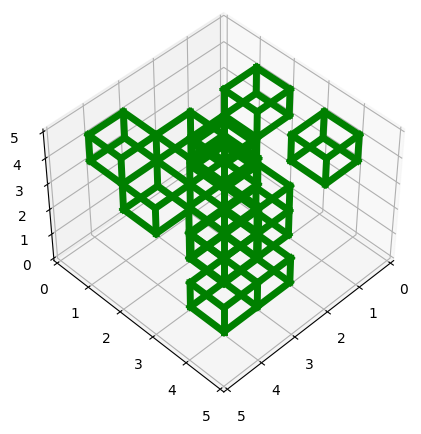

In [32]:
draw(coord, elcon, 45, 45,'green')

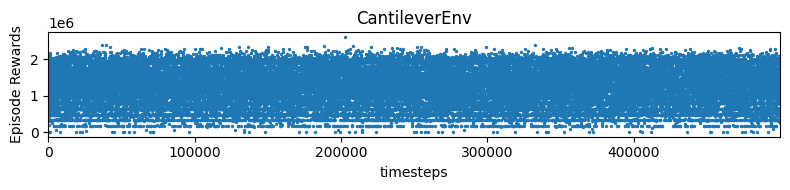

In [33]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [34]:
obs = env.reset()

In [35]:
obs = obs[0]

In [36]:
model_best = PPO.load(log_dir + "best_model.zip", env = env)

In [37]:
i=0
ans=[]
while i<1000:
    action, _states = model_best.predict(obs)
    obs, rewards, dones, _ , info = env.step(action)
    ans.append(obs)
    if dones:
        break
    
    i+=1

In [38]:
topology = reconstruct_3d_structure(ans[-1]['X_projection'].astype(np.uint8).reshape(y0,x0), 
                                    ans[-1]['Y_projection'].astype(np.uint8).reshape(y0,x0),
                                    ans[-1]['Z_projection'].astype(np.uint8).reshape(y0,x0))
coord, elcon, m = get_voxel_edge_pairs(topology)

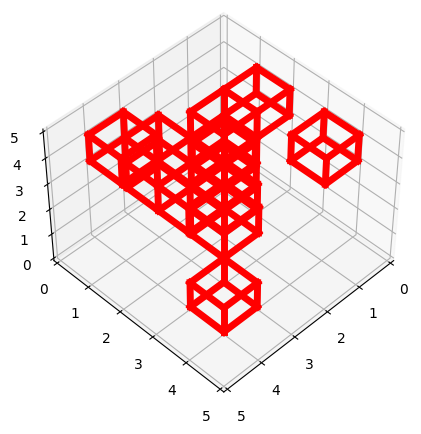

In [39]:
draw(coord, elcon, 45, 45,'red')

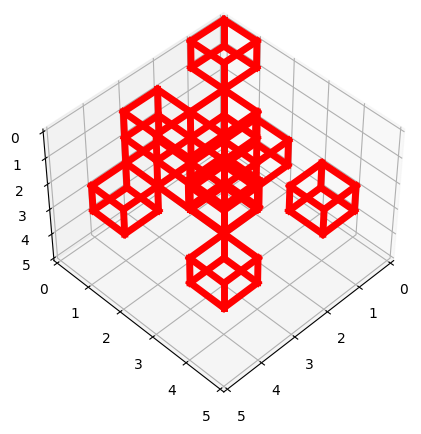

In [40]:
draw(coord, elcon, 45, 45, 'red', True)

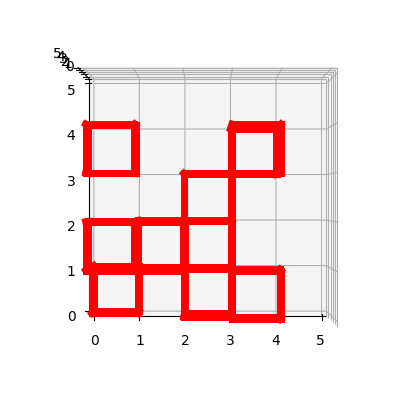

In [41]:
draw(coord, elcon, 90, -90, 'red')

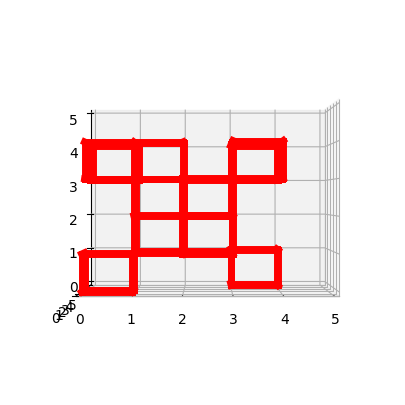

In [42]:
draw(coord, elcon, 0, -90, 'red')

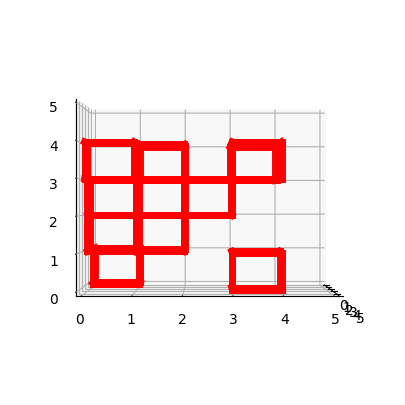

In [43]:
draw(coord, elcon, 0, 0, 'red')